In [37]:
#importing some useful packages
import pickle
import cv2
import math
import time
import h5py
import json
import os
import csv
import random
import numpy as np
import pandas as pd
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import np_utils

import theano
%matplotlib inline

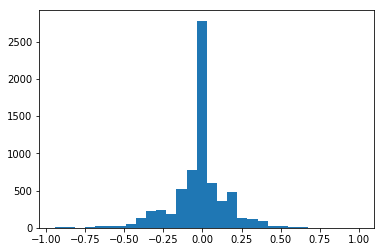

In [38]:
df = pd.read_csv('driving_log_Arun.csv')

df = df.drop(df[df['steering'] == 0].sample(frac=0.60).index)

center = df[[0]]

center = np.squeeze(center.values)
left = df[[1]]
left = np.squeeze(left.values)
right = df[[2]]
right = np.squeeze(right.values)
steering = df[[3]]
steering = np.squeeze(steering.values)
plt.hist(steering, bins = 30)
correction = 0.25
steering_left = steering + correction
steering_right = steering - correction

images = np.concatenate((np.concatenate((center, left)), right))
steer = np.concatenate((np.concatenate((steering, steering_left)), steering_right))

batch_size = 10

def remove_spaces(path):
    len_path = len(path)
    for i in range(len_path):
        if (path[i][0] == ' '):
            path[i] = path[i][1:]
    return path

images = remove_spaces(images)

row_size = 66
col_size = 200
ch = 3


In [39]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    horizontal_flip=True)

In [40]:
def data_generator(Images,steering,training=0,batch_size=10,threshold=0.15):
    ctr=0

    while( (training and ctr<len(steering) ) or (not training) ) :
    
        if ((not training) and (ctr>=len(steering))):
            ctr=0

        data,labels=preprocess(Images[ctr:ctr+batch_size],steering[ctr:ctr+batch_size],threshold)    
        ctr +=batch_size

        yield data,labels
        
def crop(img):
    #new_size_col=120
    #new_size_row=30
    img=img[60:145,:,:]
    img=cv2.resize(img,(col_size,row_size), interpolation=cv2.INTER_AREA)
    return img
        
def preprocess(Images,steering,threshold):
    row,col,ch=(mpimg.imread(Images[0])).shape

    img = []
    steer = []
        
    for i,path in enumerate(Images):

        I=mpimg.imread(path)
        #I = I/255 - 0.5
                    
        img.append(crop(I))
        steer.append(steering[i])

        if steering[i]<-threshold or steering[i]>threshold :
            I=np.fliplr(I)
            img.append(crop(I))
            steer.append(-steering[i])

    return np.asarray(img),np.asarray(steer)

'\nX = np.zeros(shape = (len(X_train), row_size, col_size, 3))\nfor i in range(len(X_train)):\n    img = mpimg.imread(X_train[i])\n    img = img/255 - 0.5\n    X[i] = crop(img)\nXtest = np.zeros(shape = (len(X_test), row_size, col_size, 3))\nfor i in range(len(X_test)):\n    img = mpimg.imread(X_test[i])\n    img = img/255 - 0.5\n    Xtest[i] = crop(img)\n'

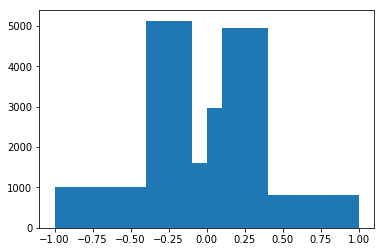

In [41]:
X_train, X_test, y_train, y_test = train_test_split(images, steer, test_size = 0.2, random_state = 0)

plt.hist(y_train, bins = [-1,-0.4,-0.1,0,0.1,0.4,1])
"""
X = np.zeros(shape = (len(X_train), row_size, col_size, 3))
for i in range(len(X_train)):
    img = mpimg.imread(X_train[i])
    img = img/255 - 0.5
    X[i] = crop(img)
Xtest = np.zeros(shape = (len(X_test), row_size, col_size, 3))
for i in range(len(X_test)):
    img = mpimg.imread(X_test[i])
    img = img/255 - 0.5
    Xtest[i] = crop(img)
"""

len(train_labels)= 17476


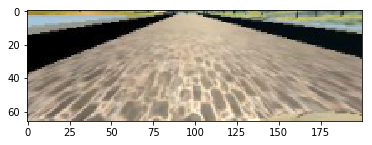

In [42]:
train_threshold=0.50
train_batch=data_generator(X_train,y_train,training=1,batch_size=128,threshold=train_threshold)

labels=[]
data=[]

try:
    count=0
    while 1:
        batch_x,batch_y=next(train_batch)
        
        if count==0:                        
            plt.imshow(batch_x[1].astype(np.uint8))
            
        count=count+1
        
        labels.append(batch_y)
        data.append(batch_x)
        
except StopIteration:
    pass

train_labels=np.concatenate( labels, axis=0 )

#print(batch_y)

samples_per_epoch = len(train_labels)
print("len(train_labels)=",len(train_labels))



len(train_labels)= 4374


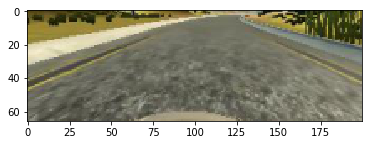

In [43]:
train_threshold=0.50
test_batch=data_generator(X_test,y_test,training=1,batch_size=128,threshold=train_threshold)

labels=[]
data=[]

try:
    count=0
    while 1:
        batch_x,batch_y=next(test_batch)
        
        if count==0:                        
            plt.imshow(batch_x[1].astype(np.uint8))
            
        count=count+1
        
        labels.append(batch_y)
        data.append(batch_x)
        
except StopIteration:
    pass

test_labels=np.concatenate( labels, axis=0 )

nb_val_samples = len(test_labels)

print("len(train_labels)=",len(test_labels))



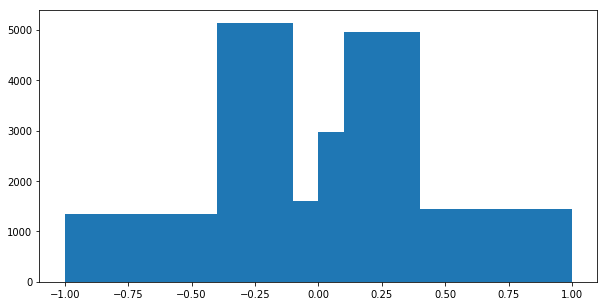

In [44]:
plt.figure(figsize=(10,5))
plt.hist(train_labels, bins = [-1, -0.4, -0.1, 0, 0.1, 0.4, 1])
plt.show()

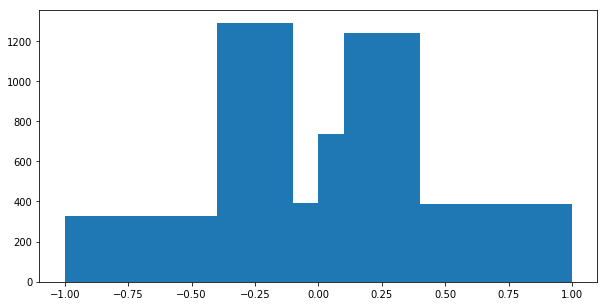

In [45]:
plt.figure(figsize=(10,5))
plt.hist(test_labels, bins = [-1, -0.4, -0.1, 0, 0.1, 0.4, 1])
plt.show()

In [46]:

model = Sequential()

model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(row_size, col_size, 3)))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal"))
model.add(Activation('relu'))

model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal"))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal"))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init="he_normal"))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init="he_normal"))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Activation('relu'))

model.add(Dense(100, init="he_normal"))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(50, init="he_normal"))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(10, init="he_normal"))
model.add(Activation('relu'))
model.add(Dense(1, init="he_normal"))

In [47]:
model.summary()


model.compile(loss='mse',
              optimizer=Adam(lr = 0.001),
              metrics=['mean_squared_error'])

model.fit_generator(data_generator(X_train,y_train,training=0,batch_size=128, threshold = 0.5),
                    samples_per_epoch=samples_per_epoch,
                    validation_data=data_generator(X_test,y_test,training=0,batch_size=128, threshold = 0.5),
                    nb_val_samples=nb_val_samples,                    
                    nb_epoch=7,
                    verbose=2)
"""
model.fit_generator(datagen.flow(X, y_train, batch_size=128),
                    samples_per_epoch=len(X_train), validation_data = datagen.flow(Xtest, y_test, batch_size=128),
                    nb_val_samples = len(Xtest), nb_epoch = 15, verbose = 2)
"""

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 66, 200, 3)    0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 31, 98, 24)    1824        lambda_3[0][0]                   
____________________________________________________________________________________________________
activation_17 (Activation)       (None, 31, 98, 24)    0           convolution2d_11[0][0]           
____________________________________________________________________________________________________
convolution2d_12 (Convolution2D) (None, 14, 47, 36)    21636       activation_17[0][0]              
___________________________________________________________________________________________

'\nmodel.fit_generator(datagen.flow(X, y_train, batch_size=128),\n                    samples_per_epoch=len(X_train), validation_data = datagen.flow(Xtest, y_test, batch_size=128),\n                    nb_val_samples = len(Xtest), nb_epoch = 15, verbose = 2)\n'

In [48]:
model.save('model.h5')